# QRNN Classification

This notebook uses the QRNN trained on GPM surface precipitation to classify raining and non-raining pixels.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import ipywidgets as w
import matplotlib.pyplot as plt
import numpy as np

# Load QRNN and data

In [2]:
from typhon.retrieval.qrnn import QRNN
qrnn = QRNN.load("qrnn_6_128.pt")
qrnn_log = QRNN.load("qrnn_6_128_log.pt")

Using TensorFlow backend.


In [3]:
from regn.data import GprofData
test_data = GprofData("../../data/validation_data_small.nc",
                      batch_size=32,
                      normalization_data="normalization_data.nc")
test_data_log = GprofData("../../data/validation_data_small.nc",
                          batch_size=32,
                          normalization_data="normalization_data.nc",
                          log_rain_rates=True)
test_data_binary = GprofData("../../data/validation_data_small.nc",
                             batch_size=32,
                             normalization_data="normalization_data.nc",
                             rain_threshold=0.1)

# Classify test data

In [4]:
def evaluate(model, data, threshold=0.1):
    """
    Compute rain probability on test set.
    
    Args:
        model: QRNN to predict probabilities.
        data: Pytorch dataset providing access to the test data.
    Returns:
        Tuple (p, y_true) of predicted probabilities p for the
        observations to be above the given threshold and the corresponding
        true binary label (raining or non-raining).
    """
    p = []
    y_true = []
    y_pred = []
    for i in range(len(data)):
        x, y = data[i]
        y_true.append(y)
        y_pred.append(model.predict(x))
        p.append(model.classify(x, threshold))
    p = np.concatenate(p, axis=0)
    y_true = np.concatenate(y_true, axis=0)
    y_true = y_true > threshold
    return p, y_true

In [16]:
p_qrnn, y_true_qrnn = evaluate(qrnn, test_data)
p_qrnn_log, y_true_qrnn_log = evaluate(qrnn_log, test_data_log, np.log10(0.1))

In [17]:
def evaluate_nn(model, data):
    """
    Compute rain probability on test set using standard neural network.
    
    Args:
        model: QRNN to predict probabilities.
        data: Pytorch dataset providing access to the binary test data.
    Returns:
        Tuple (p, y_true) of predicted probabilities p for the
        observations to be above the given threshold and the corresponding
        true binary label (raining or non-raining).
    """
    p = []
    y_true = []
    for i in range(len(data)):
        x, y = data[i]
        x = x.detach()
        y = y.detach()
        y_true.append(y)
        p.append(torch.sigmoid(model(x)).detach())
    p = np.concatenate(p, axis=0)
    y_true = np.concatenate(y_true, axis=0)
    return p, y_true

In [18]:
import torch
nn = torch.load("nn_6_128.pt")
p_nn, y_true_nn = evaluate_nn(nn, test_data_binary)

## Evaluate performance

In [19]:
from regn.utils import compute_roc
fpr_qrnn, tpr_qrnn = compute_roc(p_qrnn.ravel(), y_true_qrnn.ravel(), np.linspace(0, 1, 101))
fpr_qrnn_log, tpr_qrnn_log = compute_roc(p_qrnn_log.ravel(), y_true_qrnn_log.ravel(), np.linspace(0, 1, 101))
fpr_nn, tpr_nn = compute_roc(p_nn.ravel(), y_true_nn.ravel(), np.linspace(0, 1, 101))

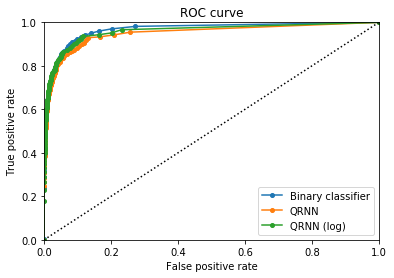

In [20]:
plt.plot(fpr_nn, tpr_nn, marker="o", label="Binary classifier", ms=4)
plt.plot(fpr, tpr, marker="o", label="QRNN", ms=4)
plt.plot(fpr_log, tpr_log, marker="o", label="QRNN (log)", ms=4)
x = np.linspace(0, 1, 1001)
plt.plot(x, x, ls = ":", c = "k")
plt.title("ROC curve")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()
plt.savefig("roc_curve.pdf", bbox_inches="tight")

## Negative log-likelihood

Log likelihood is a proper scoring rule, so it quantifies how well the predicted distribution matches the observed one. For a Bernoulli distribution the negative log-likelihood is given by:

\begin{align}
 \text{NLL} = -\frac{1}{N}\sum_i y_i \log\{p(x_i)\}  + (1 - y_i) \log \{ p_i(x) \}
 \end{align}
 
Scaling by $\frac{1}{N}$ is not formally required but makes the returned value independent of the dataset size and the NLL score identical to binary cross entropy loss.

In [61]:
def nll(p, y_true):
    return -np.mean(y_true * np.log(p) + (1 - y_true) * np.log(np.maximum(1 - p, 1e-12)))

In [62]:
nll_qrnn = nll(p_qrnn.ravel(), y_true_qrnn.ravel())
nll_qrnn_log = nll(p_qrnn_log.ravel(), y_true_qrnn_log.ravel())
nll_nn = nll(p_nn.ravel(), y_true_nn.ravel())

## Brier score

The brier score for a binary classification problem is given by

\begin{align}
 \text{BS} = 0.5 \frac{1}{N}\sum_i (y_i - p(x_i))^2  + ((1 - y_i) - p_i(x))^2
 \end{align}

In [66]:
def brier_score(p, y_true):
    return 0.5 * np.mean((y_true - p)**2 + ((1 - y_true) - (1 - p))**2)

In [67]:
bs_qrnn = brier_score(p_qrnn.ravel(), y_true_qrnn.ravel())
bs_qrnn_log = brier_score(p_qrnn_log.ravel(), y_true_qrnn_log.ravel())
bs_nn = brier_score(p_nn.ravel(), y_true_nn.ravel())

## Results

The way the scores are defined here, lower value indicate better performance. Although the NN performs slightly better, the performance of the QRNNs are comparable.

In [68]:
import pandas as pd
names = ["QRNN", "QRNN (log)", "NN"]
data = {"NLL" : [nll_qrnn, nll_qrnn_log, nll_nn],
        "Brier score" : [bs_qrnn, bs_qrnn_log, bs_nn]}
pd.DataFrame(data, index=names)

,NLL,Brier score
QRNN,0.126352,0.034381
QRNN (log),0.118225,0.032447
NN,0.112646,0.032409
